# Computational Intelligence in Chemistry - Hands-on Active Learning
### Luis Filipe Menezes - RA: 164924
This is part of an assignment for the Computational Intelligence in Chemistry course on UNIFESP's masters program.

This notebook must:

I. Use the full QM9 dataset.

II. Select one representation for the molecules (EV-CM,
MBTR, Mordred, etc.)

III. Setup a topline predictor:
  - I.Select a method, e.g., MLP, RF, KRR, etc.,
  - II.Split the dataset into train (80%), validation (10%) and test (10%)
  - III.Perform the model hyperparameter tuning

IV. Evaluate the final model with the test set

IV. Active Learning: Committee-base approach
  - I. Using the baseline model established in step III: train multiple regressors (with different seed and small hyperparameters modifications)
  - II.Use a subset of 1% of the training data to build the initial models
  - III.At each step of the active learning loop, select new samples from the training data (the number of samples must be evaluated – select a small number)
  - IV.Update the model with the new samples

V. Plot a graph showing the Error measurement versus the percentage of samples used for training

VI. Compare the active learning results with a passive (random) selection

## I. Loading the full QM9 dataset

In [1]:
!pip install --quiet dscribe

In [2]:
!wget -O data.tar.bz2 https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d&st=1cohswqh&dl=0
!!mkdir qm9_files
!tar -xjf data.tar.bz2 -C qm9_files/

--2025-11-17 13:02:56--  https://www.dropbox.com/scl/fi/2ugqxr9fa9nob1byc8ura/dsgdb9nsd.xyz.tar.bz2?rlkey=pp2k6fy4360yldrypwghwbi6d
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com/cd/0/inline/C1UpepAhjM_8nC3PIWnBWldVs5TGGpZmH4R7UrMPKjV7P-r-bUi-nN74F8n5SN8d8hU0k_Oa9tT1EwemLepckMEc9yDfxdQ0nGO27gR0KAfE94uMIav5YDhMILsLF8n7sG5miedoRFcWtNNui7WURgVh/file# [following]
--2025-11-17 13:02:57--  https://uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com/cd/0/inline/C1UpepAhjM_8nC3PIWnBWldVs5TGGpZmH4R7UrMPKjV7P-r-bUi-nN74F8n5SN8d8hU0k_Oa9tT1EwemLepckMEc9yDfxdQ0nGO27gR0KAfE94uMIav5YDhMILsLF8n7sG5miedoRFcWtNNui7WURgVh/file
Resolving uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com (uc98921f81139f6c0c48b1b8c49b.dl.dropboxusercontent.com)... 162.125.5.1

In [1]:
qm9_folder = 'qm9_files/'
QM9_PROPERTIES = [
    "A", 'B', 'C', 'mu', 'alpha',
    'homo', 'lumo', 'gap', 'r2',
    'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]


with open(qm9_folder+'dsgdb9nsd_113885.xyz') as file:
  for line in file:
    print(line)

19

gdb 113885	3.70802	0.80999	0.7081	2.6975	73.65	-0.2639	0.0141	0.278	1593.5236	0.156316	-460.174889	-460.164623	-460.163679	-460.212278	35.326	

C	-0.008898706	 1.435343511	-0.1229342875	-0.480889

C	-0.097211668	-0.0611740136	 0.0533750899	 0.431334

O	-0.522805097	-0.6329577977	 1.0223608396	-0.34442

O	 0.3874153201	-0.692641184	-1.0454419183	-0.247509

C	 0.3502508225	-2.1099666389	-1.0216443391	 0.118249

C	-0.6452778548	-2.8049992501	-1.9010293635	-0.305338

C	 0.8299955957	-2.806393386	-2.257736521	-0.04378

C	 1.3090797685	-2.0281448361	-3.4552388748	-0.093611

O	 1.0953742585	-2.8320000843	-4.6085691448	-0.419869

H	-0.3728027153	 1.9278328937	 0.7777832851	 0.149542

H	 1.0248947898	 1.7315350968	-0.3210999853	 0.149596

H	-0.6070917791	 1.7459702376	-0.9844780335	 0.149165

H	 0.576972916	-2.5190329042	-0.0453019279	 0.12476

H	-1.1102986284	-3.7153217605	-1.5406769745	 0.122235

H	-1.2860640388	-2.1730656326	-2.5065209428	 0.123942

H	 1.3703384329	-3.7344941519	-2.09474

In [2]:
import os
import pandas as pd
import numpy as np
from ase import Atoms


np.random.seed(24)
N_SUBSET_SAMPLES = 5000

def load_validate_mol(file_string):
  with open(file_string, 'r') as file:
    n_atoms = int(file.readline())

    properties_list = file.readline().split()
    mol_id = properties_list[1]
    properties_values = [float(prop) for prop in properties_list[2:]]
    properties_dict = dict(zip(QM9_PROPERTIES, properties_values))


    atoms = []
    atoms_coords = []
    for nlines in range(n_atoms):
      atom_info = file.readline().split()
      atoms.append(atom_info[0]) # get only the the atom string

      atom_coords_str = atom_info[1:4]
      # print(atom_coords)
      try:
        atom_coords = [float(coord.replace('*^', 'e')) for coord in atom_coords_str]
        atoms_coords.append(atom_coords)

      except Exception as e:
        print(f"Couldn't extract xyz from file {file_string}: ", e)
      # print(atom_info)
    # print(atoms)
    file.readline() # ignores the frequencies

    # smiles_list = file.readline().split()


    # mol = Chem.MolFromSmiles(smiles_list[0]) # If it's None then smiles is invalid
    # if mol is None:
    #     print("Invalid smiles for arquive: ", mol_id)
    #     return
    # canon_smiles = Chem.CanonSmiles(smiles_list[0])

    mol_ase = Atoms(symbols=atoms, positions= atoms_coords)

    molecule_data = {
                'id': mol_id,
                'n_atoms': n_atoms,
                'atom_list': atoms,
                'atom_coords': atoms_coords,
                'mol_ase': mol_ase,
                # 'smiles': canon_smiles,
            }
            # Adiciona as 12 propriedades ao dicionário principal
    molecule_data.update(properties_dict)
    return molecule_data


def get_full_dataset(folder):
  dataset_list = []
  # print(f"Lendo arquivos da pasta: {folder}")

  files_to_process = [f for f in os.listdir(folder) if f.endswith('.xyz')]

  # files_to_process = np.random.choice(files_to_process, size=N_SUBSET_SAMPLES, replace=False)

  n_max_atoms = -1

  for i, file in enumerate(files_to_process):

      if (i + 1) % 10000 == 0:
          print(f"  Processando arquivo {i+1}/{len(files_to_process)}...")

      file_path = os.path.join(folder, file)

      # Chama a função de processamento para um arquivo
      molecule_data = load_validate_mol(file_path)

      n_atoms = molecule_data['n_atoms']
      if n_atoms > n_max_atoms:
          n_max_atoms = n_atoms
      # Se a função retornou dados válidos (não None), adiciona à lista
      if molecule_data:
          dataset_list.append(molecule_data)
  return dataset_list, n_max_atoms




if __name__ == '__main__':
  full_dataset, n_max_atoms = get_full_dataset(qm9_folder)

  df = pd.DataFrame(full_dataset)
  display(df.head())
  # print(load_validate_mol(qm9_folder+'dsgdb9nsd_113885.xyz')['atom_coords'])

  Processando arquivo 10000/133885...
  Processando arquivo 20000/133885...
  Processando arquivo 30000/133885...
  Processando arquivo 40000/133885...
  Processando arquivo 50000/133885...
  Processando arquivo 60000/133885...
  Processando arquivo 70000/133885...
  Processando arquivo 80000/133885...
  Processando arquivo 90000/133885...
  Processando arquivo 100000/133885...
  Processando arquivo 110000/133885...
  Processando arquivo 120000/133885...
  Processando arquivo 130000/133885...


,id,n_atoms,atom_list,atom_coords,mol_ase,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,24741,12,"[O, C, C, C, C, N, C, C, O, H, H, H]","[[-0.0699318951, -0.0169722532, 0.0037600727],...","(Atom('O', [np.float64(-0.0699318951), np.floa...",3.82396,1.27192,0.95445,2.8364,72.43,-0.2671,-0.0895,0.1776,1120.5408,0.077210,-435.486068,-435.478661,-435.477717,-435.518646,26.421
1,59013,18,"[C, C, O, C, C, N, C, O, C, H, H, H, H, H, H, ...","[[-0.09942628, 1.5073785573, -0.060469828], [-...","(Atom('C', [np.float64(-0.09942628), np.float6...",3.61630,0.95013,0.88882,4.2815,75.84,-0.2121,-0.0008,0.2113,1353.0529,0.146822,-439.132298,-439.123186,-439.122242,-439.166452,33.758
2,42891,17,"[N, C, N, C, C, C, C, C, O, H, H, H, H, H, H, ...","[[-0.2258662223, 1.1701323106, -0.0879709741],...","(Atom('N', [np.float64(-0.2258662223), np.floa...",2.92914,1.57965,1.28871,3.2970,73.68,-0.2413,-0.0076,0.2337,1016.4167,0.136524,-417.938580,-417.930940,-417.929996,-417.971120,28.931
3,94738,19,"[C, C, O, C, C, O, C, O, C, H, H, H, H, H, H, ...","[[0.1258777725, 1.5942270676, 0.0153026654], [...","(Atom('C', [np.float64(0.1258777725), np.float...",2.74888,1.55133,1.26997,2.0216,70.81,-0.2498,0.0517,0.3015,1055.6243,0.158836,-460.147456,-460.139036,-460.138092,-460.180167,32.230
4,34702,15,"[N, C, C, C, C, C, C, C, N, H, H, H, H, H, H]","[[-0.1092509968, -1.1317928833, -0.1375915342]...","(Atom('N', [np.float64(-0.1092509968), np.floa...",5.18897,1.33325,1.31918,3.3817,71.48,-0.2512,0.0216,0.2728,950.8314,0.114945,-379.590819,-379.584660,-379.583716,-379.621414,24.793


# II. Molecules representation.

We will use the Coulomb Matrix since it can represent the eletronic properties at a low computational cost. Other tests with the MBTR  descriptor for the full dataset have crashed Colab's local RAM.

In [3]:
from dscribe.descriptors import CoulombMatrix, MBTR

ev_cm = CoulombMatrix(n_atoms_max=n_max_atoms, permutation='eigenspectrum')

ev_cm_descriptors = ev_cm.create(df['mol_ase'], n_jobs=-1)

print(ev_cm_descriptors[0])

[203.53045209  77.30308229  49.75955177  39.8116953   27.73080865
  13.21845693   6.40199004   5.63657148   1.46373806  -0.80071863
  -0.7598336   -0.25506634   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.        ]


# III. Setup topline predictor

We will use an MLP approach, since we do not have the full description provided by MBTR we might need more complexes models to best suit our prediction problem.

### I. Preprocessing data

Using Stardard Scaler and dividing the dataset as $20\%$ test subset.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

X_processed = scaler.fit_transform(ev_cm_descriptors)
y = df['Cv']
# y_processed = scaler.fit_transform(df[QM9_PROPERTIES])

In [5]:
X_dev, X_test, y_dev, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=24)

### III. Hyperparameter tuning

We will use cross-validation to select the best hyperparameters configuration for the MLP model.

In [11]:
import keras
from keras.layers import Dense, Input

def create_model(n_hidden_layers=2, units_per_layer=64, learning_rate=0.001, l2_reg=0.001):
  mlp = keras.Sequential()
  mlp.add(Input(shape=(X_dev.shape[1],)))
  for i in range(n_hidden_layers, 0, -1):
    mlp.add(Dense(units_per_layer*i, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
    # mlp.add(Dense(units_per_layer, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
  mlp.add(Dense(1, activation='linear'))

  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  mlp.compile(optimizer=opt, loss='mae', metrics=['r2_score'])
  return mlp

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=24)

cv_scores = []
r2_cv_scores = []
fold_no = 1

# 3. The Loop
for train_index, val_index in kf.split(X_dev, y_dev):
    print(f'Training Fold {fold_no}...')

    # Split data based on the indices provided by KFold
    X_train_fold, X_val_fold = X_dev[train_index], X_dev[val_index]
    y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

    model = create_model()

    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,          
        batch_size=64,
        verbose=0,          
        validation_data=(X_val_fold, y_val_fold)
    )

    
    # Evaluate
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Fold {fold_no} MAE: {scores[0]:.4f}') # scores[0] is the metric (MAE)

    cv_scores.append(scores[0])
    r2_cv_scores.append(scores[1])
    fold_no += 1

print(f'Average CV MAE: {np.mean(cv_scores):.4f}')
print(f'Average CV R2: {np.mean(r2_cv_scores):.4f}')

Training Fold 1...


2025-11-17 15:26:35.718522: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:26:35.718538: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:26:35.718554: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:26:36.087207: I external/l

Fold 1 MAE: 0.6391
Training Fold 2...
Fold 2 MAE: 0.6068
Training Fold 3...


2025-11-17 15:28:36.119370: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:28:36.119386: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:28:36.119412: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 15:28:36.487319: I external/l

Fold 3 MAE: 0.5766
Average CV MAE: 0.6075
Average CV R2: 0.9643


#### Training final model

In [70]:
model = create_model()
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1, random_state=24)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64, 
    validation_data=(X_val, y_val),
    verbose=0
)

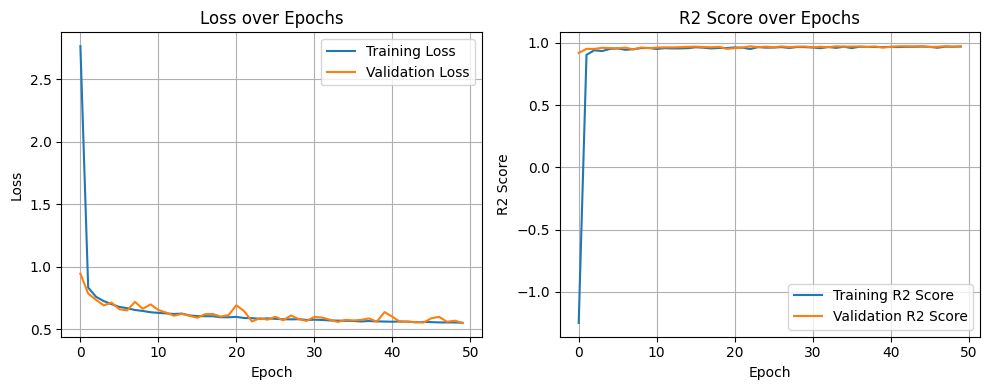

In [71]:
def plot_learning_curve(history):
    """
    Plots the training and validation loss and accuracy from a Keras history object.


    Args:
        history: A Keras History object.
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['r2_score'], label='Training R2 Score')
    plt.plot(history.history['val_r2_score'], label='Validation R2 Score')
    plt.title('R2 Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

# IV Analising in the test subset

837/837 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step


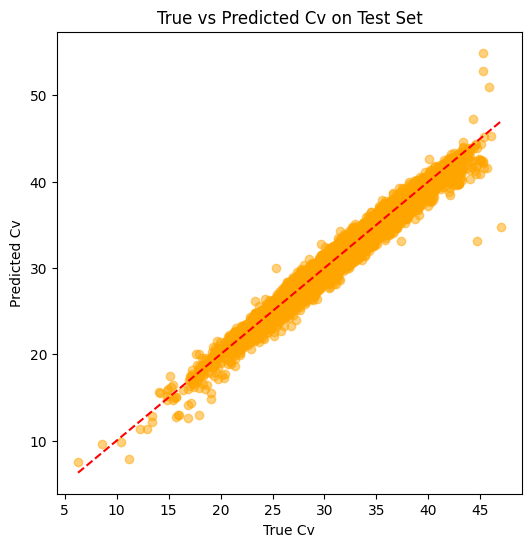

In [72]:
y_pred = model.predict(X_test)
test_metrics = model.evaluate(X_test, y_test, verbose=0)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, c='orange')
plt.xlabel('True Cv')
plt.ylabel('Predicted Cv')
plt.title('True vs Predicted Cv on Test Set')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()

In [73]:
print(f'Test MAE: {test_metrics[0]:.4f}')
print(f'Test R2: {test_metrics[1]:.4f}')

Test MAE: 0.5446
Test R2: 0.9736


837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
MAE=0.4954, RMSE=0.6592, R2=0.9736


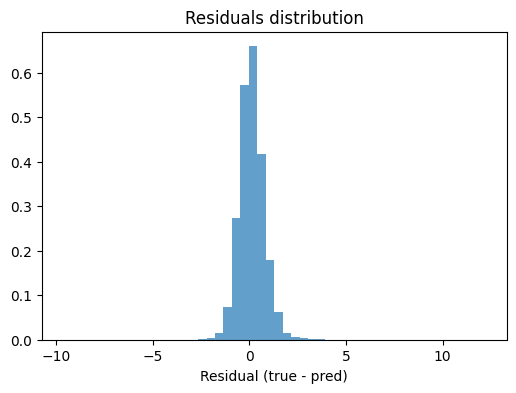

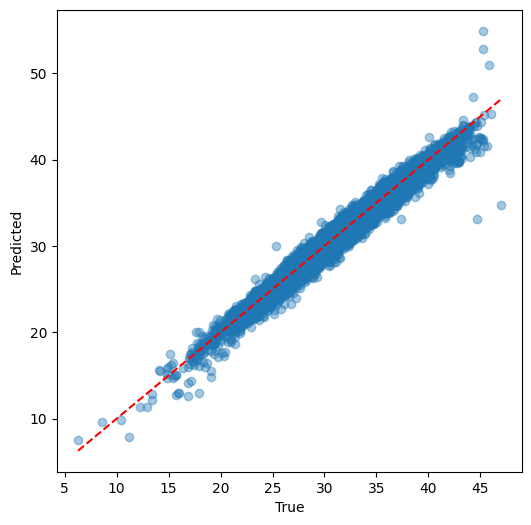

In [74]:
# Python: common metrics + residual plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test).ravel()
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, density=True, alpha=0.7)
plt.title('Residuals distribution')
plt.xlabel('Residual (true - pred)')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'r--')
plt.xlabel('True'); plt.ylabel('Predicted')
plt.show()

In [76]:
# Bootstrap CI for MAE
import numpy as np
n_boot = 1000
maes = []
rng = np.random.RandomState(0)
for _ in range(n_boot):
    idx = rng.choice(len(y_test), len(y_test), replace=True)
    maes.append(mean_absolute_error(y_test.iloc[idx], y_pred[idx]))
np.percentile(maes, [2.5, 50, 97.5])

array([0.48998256, 0.49535057, 0.50063103])

# V. Query by Commitee (QBC) - Active Learning


## I - Sorting molecules by the number of atoms


In [6]:
df['coulomb_matrix'] = list(ev_cm_descriptors)

In [7]:
df.sort_values('n_atoms').head()

,id,n_atoms,atom_list,atom_coords,mol_ase,A,B,C,mu,alpha,...,lumo,gap,r2,zpve,U0,U,H,G,Cv,coulomb_matrix
24135,5,3,"[C, N, H]","[[-0.0133239314, 1.1324657151, 0.0082758861], ...","(Atom('C', [np.float64(-0.0133239314), np.floa...",0.00000,44.593883,44.593883,2.8937,12.99,...,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,"[82.93012970521048, 8.420300583860058, -0.6336..."
49189,3,3,"[O, H, H]","[[-0.0343604951, 0.9775395708, 0.0076015923], ...","(Atom('O', [np.float64(-0.0343604951), np.floa...",799.58812,437.903860,282.945450,1.8511,6.31,...,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,"[75.37984515972862, -0.7023682000785567, -0.16..."
3283,4,4,"[C, C, H, H]","[[0.5995394918, 0.0, 1.0], [-0.5995394918, 0.0...","(Atom('C', [np.float64(0.5995394918), np.float...",0.00000,35.610036,35.610036,0.0000,16.28,...,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,"[67.9083723695334, 7.987343424180706, -0.95318..."
111766,25,4,"[N, C, C, N]","[[0.0174573422, -1.1613421749, -0.0041534236],...","(Atom('N', [np.float64(0.0174573422), np.float...",0.00000,4.732690,4.732690,0.0023,27.70,...,-0.0926,0.2770,242.9308,0.015951,-185.648533,-185.644825,-185.643880,-185.667652,10.398,"[117.70367984331759, 49.96188247859495, 11.952..."
100769,6,4,"[C, O, H, H]","[[-0.0139776956, 1.1802114286, 0.0077524981], ...","(Atom('C', [np.float64(-0.0139776956), np.floa...",285.48839,38.982300,34.298920,2.1089,14.18,...,-0.0406,0.2263,59.9891,0.026603,-114.483613,-114.480746,-114.479802,-114.505268,6.413,"[99.97505488934989, 12.156765730609523, -0.723..."


## II & III - Selecting the top 1% smallest molecules and training initial models in comittee

In [36]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf

In [37]:
import keras
from keras.layers import Dense, Input

def create_model(n_hidden_layers=2, units_per_layer=64, learning_rate=0.001, l2_reg=0.001):
  mlp = keras.Sequential()
  mlp.add(Input(shape=(X_dev.shape[1],)))
  for i in range(n_hidden_layers, 0, -1):
    mlp.add(Dense(units_per_layer*i, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)))
  mlp.add(Dense(1, activation='linear'))
  opt = keras.optimizers.Adam(learning_rate=learning_rate)
  mlp.compile(optimizer=opt, loss='mae', metrics=['r2_score'])
  return mlp

In [38]:
from sklearn.model_selection import train_test_split
import numpy as np
import random

# Reproduce previous dev/test split to get indices (same random_state as earlier)
all_idx = np.arange(len(df))
dev_idx, test_idx = train_test_split(all_idx, test_size=0.2, random_state=24)

# 1) Sort molecules of the training/dev set by number of atoms (ascending)
dev_sorted_by_atoms = dev_idx[np.argsort(df.loc[dev_idx, 'n_atoms'].values)]

# 2) Select top 1% smallest molecules as initial_training
n_initial = int(len(dev_sorted_by_atoms) * 0.01)
initial_idx = dev_sorted_by_atoms[:n_initial]

print(f"Dev size: {len(dev_idx)} | initial (1%): {n_initial} samples")

Dev size: 107108 | initial (1%): 1071 samples


In [39]:
topline_r2 = 0.9736
threshold_r2 = topline_r2 * 0.90 # stopping at 90 % of topline
print(f"Topline R2: {topline_r2:.4f} | Threshold R2: {threshold_r2:.4f}")
print("Stopping at R2 score >= threshold_r2")

Topline R2: 0.9736 | Threshold R2: 0.8762
Stopping at R2 score >= threshold_r2


In [40]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

# --- Configuração dos Dados ---
# 1. Ordenar moléculas do conjunto de desenvolvimento pelo número de átomos
# Assumindo que dev_idx e df já existem do passo anterior
dev_sorted_indices = dev_idx[np.argsort(df.loc[dev_idx, 'n_atoms'].values)]

# 2. Selecionar top 1% das menores moléculas
n_total_dev = len(dev_sorted_indices)
n_initial = int(n_total_dev * 0.01)

initial_idx = list(dev_sorted_indices[:n_initial])  # Treino Inicial
pool_idx = list(dev_sorted_indices[n_initial:])     # Pool (Remaining)

# Preparar dados iniciais
X_train_curr = X_processed[initial_idx]
y_train_curr = y.iloc[initial_idx].values

# Dados de Teste (fixos)
X_test_data = X_processed[test_idx]
y_test_data = y.iloc[test_idx].values

# --- Funções Auxiliares ---
def evaluate_committee(committee, X, y_true):
    # Predição é a média do comitê
    preds = np.stack([m.predict(X, verbose=0).flatten() for m in committee])
    mean_pred = np.mean(preds, axis=0)
    r2 = r2_score(y_true, mean_pred)
    mae = mean_absolute_error(y_true, mean_pred)
    return r2, mae

# --- 3. Treinar Modelos Iniciais (com diferenciação) ---
committee = []
n_members = 3

for i in range(n_members):
    # Diferenciação: Jitter nos neurônios e regularização
    units_jitter = int(np.random.uniform(0.9, 1.1) * 64)
    reg_jitter = np.random.uniform(0.0008, 0.0012)
    
    model = create_model(units_per_layer=units_jitter, l2_reg=reg_jitter)
    
    # Treino inicial convencional (fit)
    model.fit(X_train_curr, y_train_curr, epochs=50, batch_size=32, verbose=0)
    committee.append(model)

# 4. Avaliação Inicial
acc_r2 = []
acc_mae = []
r2, mae = evaluate_committee(committee, X_test_data, y_test_data)
acc_r2.append(r2)
acc_mae.append(mae)

print(f"Comittee Start: Train Size={len(initial_idx)} | Test R2={r2:.4f} | Test MAE={mae:.4f}")


Comittee Start: Train Size=1071 | Test R2=-46.6226 | Test MAE=25.7058


In [41]:
import numpy as np

# 1. Duplicar o pool para garantir independência entre as estratégias
pool_idx_active = list(pool_idx) # Pool exclusivo do Active Learning
pool_idx_random = list(pool_idx) # Pool exclusivo do Random Sampling

# 2. Inicializar acumuladores de dados separadamente
X_train_acc_active = np.copy(X_train_curr)
y_train_acc_active = np.copy(y_train_curr)

X_train_acc_random = np.copy(X_train_curr)
y_train_acc_random = np.copy(y_train_curr)

# 3. Inicializar e treinar o modelo aleatório base
rand_model = create_model()
rand_model.fit(X_train_curr, y_train_curr, epochs=50, batch_size=32, verbose=0)

# Avaliação Inicial Random
r2_rand, mae_rand = evaluate_committee([rand_model], X_test_data, y_test_data)
acc_r2_rand = [r2_rand]
acc_mae_rand = [mae_rand]

print(f"Start Random: Train Size={len(X_train_curr)} | Test R2={r2_rand:.4f}")

Start Random: Train Size=1071 | Test R2=-46.7516


In [42]:

# --- Loop Comparativo ---
# --- Configuração Inicial ---
samples_per_step = 5
subsample_size = 150000 # não vai fazer subsampling
iteration = 0

# Roda enquanto houver amostras em AMBOS os pools
while len(pool_idx_active) > 0 and len(pool_idx_random) > 0 and acc_r2[-1] < threshold_r2:
    iteration += 1
    
    # Tamanho do batch atual (segurança para fim do dataset)
    current_batch_size = min(samples_per_step, len(pool_idx_active))
    
    # ==========================================
    # ESTRATÉGIA 1: ACTIVE LEARNING (QBC)
    # ==========================================
    
    # A. Subsampling
    current_pool_size = len(pool_idx_active)
    n_candidates = min(subsample_size, current_pool_size)
    print(f"  [Active] Pool Size: {current_pool_size} | Candidates: {n_candidates}")
    indices_in_pool_list = np.random.choice(current_pool_size, size=n_candidates, replace=False)
    global_candidates_idx = [pool_idx_active[i] for i in indices_in_pool_list]
    X_candidates = X_processed[global_candidates_idx]
    
    # B. Incerteza
    preds = np.stack([m.predict(X_candidates, verbose=0).flatten() for m in committee])
    uncertainties = np.std(preds, axis=0)
    
    # C. Seleção (Top N incertezas)
    best_candidates_rel_idx = np.argsort(uncertainties)[-current_batch_size:]
    indices_to_remove_active = [indices_in_pool_list[i] for i in best_candidates_rel_idx]
    selected_global_idx_active = [pool_idx_active[i] for i in indices_to_remove_active]
    
    # D. Atualização Active
    X_new_active = X_processed[selected_global_idx_active]
    y_new_active = y.iloc[selected_global_idx_active].values
    
    X_train_acc_active = np.vstack((X_train_acc_active, X_new_active))
    y_train_acc_active = np.concatenate((y_train_acc_active, y_new_active))
    
    # Remover do pool Active
    for idx in sorted(indices_to_remove_active, reverse=True):
        pool_idx_active.pop(idx)
        
    # E. Retreino Active (Fine-tuning)
    for model in committee:
        model.fit(X_train_acc_active, y_train_acc_active, epochs=4, batch_size=32, verbose=0)

    # ==========================================
    # ESTRATÉGIA 2: RANDOM SAMPLING
    # ==========================================
    
    # A. Seleção Aleatória (direto do pool random)
    # Escolhe índices aleatórios dentro da lista pool_idx_random
    indices_to_remove_rand = np.random.choice(len(pool_idx_random), size=current_batch_size, replace=False)
    selected_global_idx_rand = [pool_idx_random[i] for i in indices_to_remove_rand]
    
    # B. Atualização Random
    X_new_rand = X_processed[selected_global_idx_rand]
    y_new_rand = y.iloc[selected_global_idx_rand].values
    
    X_train_acc_random = np.vstack((X_train_acc_random, X_new_rand))
    y_train_acc_random = np.concatenate((y_train_acc_random, y_new_rand))
    
    # Remover do pool Random (sort reverse obrigatório)
    for idx in sorted(indices_to_remove_rand, reverse=True):
        pool_idx_random.pop(idx)
        
    # C. Retreino Random (Fine-tuning)
    rand_model.fit(X_train_acc_random, y_train_acc_random, epochs=4, batch_size=32, verbose=0)

    # ==========================================
    # AVALIAÇÃO E LOG
    # ==========================================
    
    # Avaliar Active
    r2_act, mae_act = evaluate_committee(committee, X_test_data, y_test_data)
    acc_r2.append(r2_act)
    acc_mae.append(mae_act)
    
    # Avaliar Random
    r2_rand, mae_rand = evaluate_committee([rand_model], X_test_data, y_test_data)
    acc_r2_rand.append(r2_rand)
    acc_mae_rand.append(mae_rand)
    
    avg_unc = np.mean(uncertainties[best_candidates_rel_idx])
    
    print(f"Iter {iteration}: +{current_batch_size} samples")
    print(f"   [Active] R2: {r2_act:.4f} | MAE: {mae_act:.4f} | Unc: {avg_unc:.4f}")
    print(f"   [Random] R2: {r2_rand:.4f} | MAE: {mae_rand:.4f}")
    print("-" * 50)

  [Active] Pool Size: 106037 | Candidates: 106037
Iter 1: +5 samples
   [Active] R2: -45.8515 | MAE: 25.4618 | Unc: 2.8427
   [Random] R2: -45.6336 | MAE: 25.6852
--------------------------------------------------
  [Active] Pool Size: 106032 | Candidates: 106032
Iter 2: +5 samples
   [Active] R2: -44.7907 | MAE: 25.2302 | Unc: 2.4363
   [Random] R2: -44.5878 | MAE: 25.4281
--------------------------------------------------
  [Active] Pool Size: 106027 | Candidates: 106027
Iter 3: +5 samples
   [Active] R2: -39.2645 | MAE: 23.8051 | Unc: 3.4366
   [Random] R2: -42.6987 | MAE: 24.8921
--------------------------------------------------
  [Active] Pool Size: 106022 | Candidates: 106022
Iter 4: +5 samples
   [Active] R2: -36.3047 | MAE: 22.8930 | Unc: 9.0830
   [Random] R2: -38.4994 | MAE: 23.6954
--------------------------------------------------
  [Active] Pool Size: 106017 | Candidates: 106017
Iter 5: +5 samples
   [Active] R2: -35.2239 | MAE: 22.6288 | Unc: 20.7224
   [Random] R2: -13.

In [ ]:
import numpy as np
from sklearn.utils import resample

# --- Configurações ---
samples_per_step = 5
subsample_size = 5000  # Aumentei para garantir cobertura
epochs_reset = 50      # Épocas para treinar do zero a cada passo

# --- Inicialização ---
# Duplicar pools e acumuladores
pool_idx_active = list(pool_idx)
pool_idx_random = list(pool_idx)

X_train_acc_active = np.copy(X_train_curr)
y_train_acc_active = np.copy(y_train_curr)

X_train_acc_random = np.copy(X_train_curr)
y_train_acc_random = np.copy(y_train_curr)

# Listas de métricas
acc_r2_active = []
acc_mae_active = []
acc_r2_rand = []
acc_mae_rand = []

print(f"Start Benchmarking: Initial Train Size={len(X_train_curr)}")

iteration = 0

while len(pool_idx_active) > 0 and len(pool_idx_random) > 0:
    iteration += 1
    current_batch_size = min(samples_per_step, len(pool_idx_active))
    
    # ==========================================
    # 1. TREINAR COMITÊ ATUAL (RETRAIN FROM SCRATCH)
    # ==========================================
    # Recriamos o comitê do zero usando os dados acumulados do Active
    # Isso garante que a incerteza medida seja real, e não vício de pesos antigos
    current_committee = []
    for i in range(3): # 3 membros
        # Cria modelo limpo
        m = create_model(
            units_per_layer=int(np.random.uniform(0.85, 1.15) * 64), 
            l2_reg=np.random.uniform(0.0008, 0.0012)
        )
        
        # BAGGING: Cada membro vê um resample diferente do acumulado
        # Isso FORÇA desacordo em pontos difíceis
        X_bag, y_bag = resample(X_train_acc_active, y_train_acc_active, replace=True, random_state=i+iteration)
        
        m.fit(X_bag, y_bag, epochs=epochs_reset, batch_size=32, verbose=0)
        current_committee.append(m)

    # ==========================================
    # 2. ESTRATÉGIA ACTIVE (QUERY)
    # ==========================================
    # Subsample do Pool Active
    curr_pool_size = len(pool_idx_active)
    n_cand = min(subsample_size, curr_pool_size)
    
    idx_in_pool = np.random.choice(curr_pool_size, size=n_cand, replace=False)
    global_cand_idx = [pool_idx_active[i] for i in idx_in_pool]
    X_cand = X_processed[global_cand_idx]
    
    # Calcular incerteza
    preds = np.stack([m.predict(X_cand, verbose=0).flatten() for m in current_committee])
    uncertainties = np.std(preds, axis=0)
    
    # Selecionar top incertezas
    top_rel_idx = np.argsort(uncertainties)[-current_batch_size:]
    idx_to_remove_act = [idx_in_pool[i] for i in top_rel_idx]
    sel_global_idx_act = [pool_idx_active[i] for i in idx_to_remove_act]
    
    # Atualizar dados Active
    X_new_act = X_processed[sel_global_idx_act]
    y_new_act = y.iloc[sel_global_idx_act].values
    
    X_train_acc_active = np.vstack((X_train_acc_active, X_new_act))
    y_train_acc_active = np.concatenate((y_train_acc_active, y_new_act))
    
    # Remover do pool Active
    for idx in sorted(idx_to_remove_act, reverse=True):
        pool_idx_active.pop(idx)

    # ==========================================
    # 3. ESTRATÉGIA RANDOM
    # ==========================================
    # Seleção
    idx_to_remove_rnd = np.random.choice(len(pool_idx_random), size=current_batch_size, replace=False)
    sel_global_idx_rnd = [pool_idx_random[i] for i in idx_to_remove_rnd]
    
    # Atualizar dados Random
    X_new_rnd = X_processed[sel_global_idx_rnd]
    y_new_rnd = y.iloc[sel_global_idx_rnd].values
    
    X_train_acc_random = np.vstack((X_train_acc_random, X_new_rnd))
    y_train_acc_random = np.concatenate((y_train_acc_random, y_new_rnd))
    
    # Remover do pool Random
    for idx in sorted(idx_to_remove_rnd, reverse=True):
        pool_idx_random.pop(idx)
        
    # Treinar Modelo Random (Também do zero para ser justo)
    curr_rand_model = create_model()
    curr_rand_model.fit(X_train_acc_random, y_train_acc_random, epochs=epochs_reset, batch_size=32, verbose=0)

    # ==========================================
    # 4. AVALIAÇÃO
    # ==========================================
    r2_act, mae_act = evaluate_committee(current_committee, X_test_data, y_test_data)
    r2_rnd, mae_rnd = evaluate_committee([curr_rand_model], X_test_data, y_test_data)
    
    acc_r2_active.append(r2_act)
    acc_r2_rand.append(r2_rnd)
    
    avg_unc = np.mean(uncertainties[top_rel_idx])
    
    print(f"Iter {iteration}: +{current_batch_size} samples")
    print(f"   [Active] R2: {r2_act:.4f} | Unc: {avg_unc:.4f}")
    print(f"   [Random] R2: {r2_rnd:.4f}")
    
    # Check de sanidade: Se Active estiver perdendo feio, avisa
    if r2_rnd > r2_act + 0.05:
        print("   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.")
    print("-" * 40)

Start Benchmarking: Initial Train Size=1071
Iter 1: +5 samples
   [Active] R2: -46.2919 | Unc: 2.8359
   [Random] R2: -23.2357
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:03:26.130376: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:03:26.649230: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 24 bytes spill stores, 24 bytes spill loads

2025-11-25 19:03:27.310117: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:03:30.296154: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set do

Iter 2: +5 samples
   [Active] R2: -37.0096 | Unc: 3.3924
   [Random] R2: -11.8177
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:03:45.220344: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:03:45.220360: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:03:45.220375: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:03:45.721245: I external/l

Iter 3: +5 samples
   [Active] R2: -22.2771 | Unc: 13.1083
   [Random] R2: -3.9536
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:04:11.695362: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:04:11.695377: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:04:11.695392: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:04:12.054007: I external/l

Iter 4: +5 samples
   [Active] R2: -22.9724 | Unc: 15.6930
   [Random] R2: -1.8231
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:04:24.127191: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:04:24.127204: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:04:24.127219: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:04:24.720421: I external/l

Iter 5: +5 samples
   [Active] R2: -21.6480 | Unc: 10.6050
   [Random] R2: -1.7909
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:04:46.857828: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:04:47.323629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 24 bytes spill stores, 24 bytes spill loads



Iter 6: +5 samples
   [Active] R2: -19.2173 | Unc: 14.2938
   [Random] R2: -0.2803
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 7: +5 samples
   [Active] R2: -17.5898 | Unc: 15.6467
   [Random] R2: -0.3510
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:05:22.605401: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:05:22.605415: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:05:23.063661: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 44 bytes spill stores, 44 bytes spill loads

2025-11-25 19:05:23.130581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 8: +5 samples
   [Active] R2: -18.5835 | Unc: 8.6296
   [Random] R2: -0.3628
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:05:40.532885: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:05:40.909142: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 68 bytes spill stores, 68 bytes spill loads

2025-11-25 19:05:40.991658: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 444 bytes spill stores, 444 bytes spill loads



Iter 9: +5 samples
   [Active] R2: -19.6536 | Unc: 12.6939
   [Random] R2: -0.0884
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:06:03.996796: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:06:03.996811: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:06:04.404971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:06:04.475043: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 10: +5 samples
   [Active] R2: -16.7166 | Unc: 6.1605
   [Random] R2: -0.1181
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:06:14.453176: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:06:14.900152: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 24 bytes spill stores, 24 bytes spill loads

2025-11-25 19:06:29.689666: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 12 bytes spill stores, 12 bytes spill loads



Iter 11: +5 samples
   [Active] R2: -14.7295 | Unc: 7.5710
   [Random] R2: -0.0786
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 12: +5 samples
   [Active] R2: -13.4746 | Unc: 10.5585
   [Random] R2: -0.0024
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:06:56.254426: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:06:56.254441: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:06:56.254455: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:06:56.766099: I external/l

Iter 13: +5 samples
   [Active] R2: -13.5925 | Unc: 6.9203
   [Random] R2: -0.0484
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:07:08.225579: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:07:08.364277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:07:08.487966: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 8 bytes spill stores, 8 bytes spill loads

2025-11-25 19:07:08.559398: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 56 bytes spi

Iter 14: +5 samples
   [Active] R2: -15.2816 | Unc: 9.1970
   [Random] R2: 0.0989
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:07:30.269269: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:07:30.269283: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:07:30.601628: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads

2025-11-25 19:07:30.627732: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 15: +5 samples
   [Active] R2: -15.2285 | Unc: 31.2574
   [Random] R2: 0.1117
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:07:52.043070: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:07:52.043085: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:07:52.317416: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:07:52.365728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 16: +5 samples
   [Active] R2: -13.9676 | Unc: 6.7210
   [Random] R2: 0.1679
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:08:02.984264: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:08:02.984279: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:08:03.413019: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:08:03.442537: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 17: +5 samples
   [Active] R2: -13.3871 | Unc: 8.8673
   [Random] R2: 0.1409
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:08:28.649050: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 18: +5 samples
   [Active] R2: -12.7495 | Unc: 12.1084
   [Random] R2: 0.1524
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 19: +5 samples
   [Active] R2: -11.5185 | Unc: 5.7104
   [Random] R2: 0.2229
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 20: +5 samples
   [Active] R2: -11.0342 | Unc: 4.7207
   [Random] R2: 0.3554
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:09:14.656313: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:09:14.656328: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:09:15.131146: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:09:15.212820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 21: +5 samples
   [Active] R2: -12.0297 | Unc: 9.0278
   [Random] R2: 0.2000
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:09:36.334347: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:09:36.334362: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:09:36.813107: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:09:36.866579: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 22: +5 samples
   [Active] R2: -10.7583 | Unc: 6.0770
   [Random] R2: 0.2202
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:09:51.015157: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:09:51.015172: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:09:51.522778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:09:51.541264: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 23: +5 samples
   [Active] R2: -11.5767 | Unc: 5.7737
   [Random] R2: 0.1658
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:10:14.547823: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 8 bytes spill stores, 8 bytes spill loads



Iter 24: +5 samples
   [Active] R2: -9.7970 | Unc: 4.7696
   [Random] R2: 0.2522
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 25: +5 samples
   [Active] R2: -9.5980 | Unc: 6.3213
   [Random] R2: 0.3421
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 26: +5 samples
   [Active] R2: -9.6288 | Unc: 4.2820
   [Random] R2: 0.3086
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:11:12.825421: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:11:12.825436: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:11:13.293689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:11:13.352711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 27: +5 samples
   [Active] R2: -10.0867 | Unc: 3.5672
   [Random] R2: 0.3066
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:11:23.825113: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:11:23.825128: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:11:31.351062: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 28: +5 samples
   [Active] R2: -9.7508 | Unc: 5.4438
   [Random] R2: 0.3438
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:11:42.113721: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:11:42.113736: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:11:42.596518: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:11:42.650359: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 29: +5 samples
   [Active] R2: -8.7157 | Unc: 4.5025
   [Random] R2: 0.5040
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 30: +5 samples
   [Active] R2: -8.4735 | Unc: 10.6666
   [Random] R2: 0.4282
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:12:20.520629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 31: +5 samples
   [Active] R2: -7.8284 | Unc: 4.5714
   [Random] R2: 0.3844
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 32: +5 samples
   [Active] R2: -7.6721 | Unc: 6.6182
   [Random] R2: 0.4885
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 33: +5 samples
   [Active] R2: -7.5635 | Unc: 6.0682
   [Random] R2: 0.4912
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:13:11.019718: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:13:11.019734: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:13:11.484150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 540 bytes spill stores, 404 bytes spill loads

2025-11-25 19:13:11.520434: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

Iter 34: +5 samples
   [Active] R2: -7.8760 | Unc: 3.7677
   [Random] R2: 0.4666
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 35: +5 samples
   [Active] R2: -7.9916 | Unc: 4.4707
   [Random] R2: 0.3129
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:13:47.560719: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:13:47.560735: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:13:48.001032: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:13:48.086529: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 36: +5 samples
   [Active] R2: -6.9118 | Unc: 4.5979
   [Random] R2: 0.4634
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 37: +5 samples
   [Active] R2: -7.0401 | Unc: 5.5094
   [Random] R2: 0.4314
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 38: +5 samples
   [Active] R2: -5.5399 | Unc: 4.1375
   [Random] R2: 0.4408
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 39: +5 samples
   [Active] R2: -5.9670 | Unc: 6.1610
   [Random] R2: 0.3493
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 40: +5 samples
   [Active] R2: -5.8363 | Unc: 4.0830
   [Random] R2: 0.4935
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:15:17.498962: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:15:17.498977: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:15:17.779000: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:15:17.874061: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 41: +5 samples
   [Active] R2: -5.3316 | Unc: 4.1962
   [Random] R2: 0.5270
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:15:40.143942: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:15:40.147447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 42: +5 samples
   [Active] R2: -5.7334 | Unc: 4.0469
   [Random] R2: 0.2454
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 43: +5 samples
   [Active] R2: -5.0398 | Unc: 4.0337
   [Random] R2: 0.4852
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 44: +5 samples
   [Active] R2: -4.4740 | Unc: 3.6977
   [Random] R2: 0.5323
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 45: +5 samples
   [Active] R2: -4.2835 | Unc: 3.6179
   [Random] R2: 0.5076
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 46: +5 samples
   [Active] R2: -4.6897 | Unc: 5.1484
   [Random] R2: 0.4941
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:17:11.932992: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:17:11.933005: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:17:12.335828: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:17:12.455317: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 47: +5 samples
   [Active] R2: -4.1324 | Unc: 3.6602
   [Random] R2: 0.5395
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:17:34.678588: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:17:34.678603: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:17:35.013874: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads

2025-11-25 19:17:35.079281: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 48: +5 samples
   [Active] R2: -3.0192 | Unc: 3.7495
   [Random] R2: 0.5929
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 49: +5 samples
   [Active] R2: -2.8825 | Unc: 3.9415
   [Random] R2: 0.5562
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 50: +5 samples
   [Active] R2: -3.0639 | Unc: 3.1128
   [Random] R2: 0.6102
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:18:26.634819: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 51: +5 samples
   [Active] R2: -2.9519 | Unc: 3.1191
   [Random] R2: 0.4793
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 52: +5 samples
   [Active] R2: -2.7594 | Unc: 3.5026
   [Random] R2: 0.5963
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 53: +5 samples
   [Active] R2: -2.5277 | Unc: 3.1714
   [Random] R2: 0.6205
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 54: +5 samples
   [Active] R2: -2.3549 | Unc: 2.7389
   [Random] R2: 0.4999
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:19:35.188442: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:19:35.188457: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:19:35.429722: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:19:35.515486: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 55: +5 samples
   [Active] R2: -2.2624 | Unc: 3.0951
   [Random] R2: 0.4391
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 56: +5 samples
   [Active] R2: -2.2293 | Unc: 3.8559
   [Random] R2: 0.5554
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 57: +5 samples
   [Active] R2: -1.9275 | Unc: 3.4591
   [Random] R2: 0.5752
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:20:30.226828: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 58: +5 samples
   [Active] R2: -1.8938 | Unc: 3.4690
   [Random] R2: 0.5927
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:20:49.007902: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:20:49.032862: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:20:52.763504: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:20:52.763520: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set do

Iter 59: +5 samples
   [Active] R2: -1.5677 | Unc: 3.0819
   [Random] R2: 0.6092
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:21:16.040783: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:21:16.040798: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:21:16.502355: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:21:16.585773: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 60: +5 samples
   [Active] R2: -1.7157 | Unc: 3.4920
   [Random] R2: 0.5468
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 61: +5 samples
   [Active] R2: -1.1769 | Unc: 2.7742
   [Random] R2: 0.5781
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 62: +5 samples
   [Active] R2: -1.3359 | Unc: 2.9070
   [Random] R2: 0.6242
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 63: +5 samples
   [Active] R2: -1.3565 | Unc: 3.6955
   [Random] R2: 0.6484
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 64: +5 samples
   [Active] R2: -0.8482 | Unc: 3.5008
   [Random] R2: 0.5892
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:23:03.243442: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:23:03.243457: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:23:03.771366: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:23:03.802761: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 66: +5 samples
   [Active] R2: -0.7345 | Unc: 3.3474
   [Random] R2: 0.6840
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:23:14.779075: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:23:15.124356: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 540 bytes spill stores, 404 bytes spill loads

2025-11-25 19:23:22.634649: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads



Iter 67: +5 samples
   [Active] R2: -0.3552 | Unc: 3.2329
   [Random] R2: 0.6088
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:23:40.254332: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:23:40.254346: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:23:40.717628: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:23:40.778492: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 68: +5 samples
   [Active] R2: -0.3749 | Unc: 2.6011
   [Random] R2: 0.6354
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 69: +5 samples
   [Active] R2: -0.2477 | Unc: 3.9456
   [Random] R2: 0.6424
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 70: +5 samples
   [Active] R2: -0.1249 | Unc: 2.9567
   [Random] R2: 0.5934
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 71: +5 samples
   [Active] R2: -0.1113 | Unc: 3.5074
   [Random] R2: 0.6323
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:24:56.887633: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:24:56.916079: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads



Iter 72: +5 samples
   [Active] R2: -0.0169 | Unc: 2.8004
   [Random] R2: 0.6418
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 73: +5 samples
   [Active] R2: -0.1750 | Unc: 2.6958
   [Random] R2: 0.7020
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:25:32.332045: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:25:32.332061: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:25:32.710983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:25:32.794445: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 74: +5 samples
   [Active] R2: -0.0474 | Unc: 3.1941
   [Random] R2: 0.6913
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 75: +5 samples
   [Active] R2: -0.3327 | Unc: 2.8144
   [Random] R2: 0.7450
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 76: +5 samples
   [Active] R2: -0.0357 | Unc: 3.1546
   [Random] R2: 0.7219
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 77: +5 samples
   [Active] R2: 0.0483 | Unc: 2.9714
   [Random] R2: 0.7291
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 78: +5 samples
   [Active] R2: 0.0679 | Unc: 2.9952
   [Random] R2: 0.7319
   >>> AVISO: Random vencendo por margem alta. Verifique outl

2025-11-25 19:27:14.309676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:27:18.016274: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:27:18.016289: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:27:18.434221: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 80: +5 samples
   [Active] R2: -0.0705 | Unc: 3.0989
   [Random] R2: 0.7586
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:27:29.345547: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:27:33.034711: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:27:33.063808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:27:36.639605: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by u

Iter 81: +5 samples
   [Active] R2: 0.0333 | Unc: 3.5134
   [Random] R2: 0.7364
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 82: +5 samples
   [Active] R2: -0.1830 | Unc: 2.6812
   [Random] R2: 0.7310
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 83: +5 samples
   [Active] R2: -0.1012 | Unc: 2.6432
   [Random] R2: 0.7566
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 84: +5 samples
   [Active] R2: 0.0830 | Unc: 2.7690
   [Random] R2: 0.7344
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 85: +5 samples
   [Active] R2: 0.1895 | Unc: 2.6343
   [Random] R2: 0.7681
   >>> AVISO: Random vencendo por margem alta. Verifique outli

2025-11-25 19:28:58.495162: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:28:58.495176: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:28:58.895620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 44 bytes spill stores, 44 bytes spill loads

2025-11-25 19:28:58.981615: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 86: +5 samples
   [Active] R2: 0.2990 | Unc: 2.4377
   [Random] R2: 0.7659
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:29:17.090832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 12 bytes spill stores, 12 bytes spill loads



Iter 87: +5 samples
   [Active] R2: 0.3347 | Unc: 2.7910
   [Random] R2: 0.7189
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 88: +5 samples
   [Active] R2: 0.2043 | Unc: 2.9283
   [Random] R2: 0.7643
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 89: +5 samples
   [Active] R2: 0.2036 | Unc: 2.1954
   [Random] R2: 0.7525
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 90: +5 samples
   [Active] R2: 0.3793 | Unc: 2.8192
   [Random] R2: 0.7850
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:30:30.756815: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:30:30.756834: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:30:31.004382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:30:31.082089: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 91: +5 samples
   [Active] R2: 0.4083 | Unc: 3.3719
   [Random] R2: 0.7509
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:30:54.145587: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:30:54.145601: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:30:54.597902: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:30:54.675408: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 92: +5 samples
   [Active] R2: 0.3518 | Unc: 2.8895
   [Random] R2: 0.7663
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:31:17.776032: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:31:17.776047: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:31:18.085374: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads

2025-11-25 19:31:18.131238: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 93: +5 samples
   [Active] R2: 0.3813 | Unc: 3.5597
   [Random] R2: 0.7481
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 94: +5 samples
   [Active] R2: 0.4100 | Unc: 2.6108
   [Random] R2: 0.7836
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 95: +5 samples
   [Active] R2: 0.4990 | Unc: 2.3189
   [Random] R2: 0.7628
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 96: +5 samples
   [Active] R2: 0.5585 | Unc: 2.1081
   [Random] R2: 0.7733
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:32:33.570119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 97: +5 samples
   [Active] R2: 0.4639 | Unc: 2.6242
   [Random] R2: 0.7755
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:32:49.140174: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:32:49.140189: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:32:49.528996: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:32:49.720419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 98: +5 samples
   [Active] R2: 0.4920 | Unc: 2.2567
   [Random] R2: 0.7750
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 99: +5 samples
   [Active] R2: 0.5362 | Unc: 2.1882
   [Random] R2: 0.7699
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 100: +5 samples
   [Active] R2: 0.5766 | Unc: 2.4807
   [Random] R2: 0.7641
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 101: +5 samples
   [Active] R2: 0.5645 | Unc: 2.9121
   [Random] R2: 0.8089
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 102: +5 samples
   [Active] R2: 0.4735 | Unc: 2.7265
   [Random] R2: 0.7452
   >>> AVISO: Random vencendo por margem alta. Verifique outl

2025-11-25 19:35:07.840626: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:35:07.840642: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:35:08.227313: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:35:08.372720: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 105: +5 samples
   [Active] R2: 0.5862 | Unc: 2.5444
   [Random] R2: 0.8060
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:35:23.943912: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:35:23.943926: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:35:24.378056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 44 bytes spill stores, 44 bytes spill loads

2025-11-25 19:35:24.489663: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 106: +5 samples
   [Active] R2: 0.6518 | Unc: 2.8278
   [Random] R2: 0.7867
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 107: +5 samples
   [Active] R2: 0.6084 | Unc: 2.7047
   [Random] R2: 0.8101
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 108: +5 samples
   [Active] R2: 0.6070 | Unc: 2.4137
   [Random] R2: 0.7558
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 109: +5 samples
   [Active] R2: 0.5203 | Unc: 2.6948
   [Random] R2: 0.8005
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 110: +5 samples
   [Active] R2: 0.5607 | Unc: 2.3159
   [Random] R2: 0.7611
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:37:07.128382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 111: +5 samples
   [Active] R2: 0.6135 | Unc: 2.1679
   [Random] R2: 0.8198
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 112: +5 samples
   [Active] R2: 0.5952 | Unc: 2.5244
   [Random] R2: 0.8221
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:37:45.669035: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:37:45.669050: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:37:46.159019: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:37:46.249148: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 113: +5 samples
   [Active] R2: 0.6114 | Unc: 2.3447
   [Random] R2: 0.8077
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 114: +5 samples
   [Active] R2: 0.6334 | Unc: 2.3288
   [Random] R2: 0.7832
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 115: +5 samples
   [Active] R2: 0.6453 | Unc: 2.4724
   [Random] R2: 0.7879
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 116: +5 samples
   [Active] R2: 0.6185 | Unc: 2.3436
   [Random] R2: 0.7858
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:38:55.706732: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:38:59.734671: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:38:59.734686: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:39:00.049671: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 117: +5 samples
   [Active] R2: 0.6128 | Unc: 2.3120
   [Random] R2: 0.7912
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:39:16.113453: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:39:16.113468: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:39:16.347989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:39:16.402540: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 118: +5 samples
   [Active] R2: 0.5908 | Unc: 2.4199
   [Random] R2: 0.7899
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 119: +5 samples
   [Active] R2: 0.6585 | Unc: 2.4588
   [Random] R2: 0.7891
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 120: +5 samples
   [Active] R2: 0.6185 | Unc: 2.5443
   [Random] R2: 0.8020
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 121: +5 samples
   [Active] R2: 0.6758 | Unc: 2.2972
   [Random] R2: 0.7745
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 122: +5 samples
   [Active] R2: 0.6709 | Unc: 2.2492
   [Random] R2: 0.8044
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:41:35.731865: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:41:35.765439: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:41:39.875063: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:41:39.875078: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does

Iter 125: +5 samples
   [Active] R2: 0.6701 | Unc: 1.9005
   [Random] R2: 0.8388
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 126: +5 samples
   [Active] R2: 0.6281 | Unc: 2.2983
   [Random] R2: 0.7946
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 127: +5 samples
   [Active] R2: 0.6285 | Unc: 2.0416
   [Random] R2: 0.8310
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 128: +5 samples
   [Active] R2: 0.6593 | Unc: 2.1976
   [Random] R2: 0.8218
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 129: +5 samples
   [Active] R2: 0.5786 | Unc: 2.1687
   [Random] R2: 0.8199
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:43:16.722135: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:43:16.722150: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:43:17.257755: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 44 bytes spill stores, 44 bytes spill loads

2025-11-25 19:43:17.323414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 130: +5 samples
   [Active] R2: 0.6156 | Unc: 2.3509
   [Random] R2: 0.8255
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 131: +5 samples
   [Active] R2: 0.6170 | Unc: 2.2863
   [Random] R2: 0.8306
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:43:56.666847: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:44:01.120071: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 132: +5 samples
   [Active] R2: 0.6526 | Unc: 2.2993
   [Random] R2: 0.7935
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 133: +5 samples
   [Active] R2: 0.6530 | Unc: 2.1773
   [Random] R2: 0.7551
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 134: +5 samples
   [Active] R2: 0.7119 | Unc: 1.9595
   [Random] R2: 0.8092
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 135: +5 samples
   [Active] R2: 0.7425 | Unc: 2.2213
   [Random] R2: 0.8260
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 136: +5 samples
   [Active] R2: 0.7097 | Unc: 2.4114
   [Random] R2: 0.8126
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:45:32.266947: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:45:32.266962: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:45:32.600460: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads

2025-11-25 19:45:32.653287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 137: +5 samples
   [Active] R2: 0.6727 | Unc: 2.1903
   [Random] R2: 0.8022
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:46:00.047474: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 138: +5 samples
   [Active] R2: 0.6835 | Unc: 1.8881
   [Random] R2: 0.7391
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 139: +5 samples
   [Active] R2: 0.6985 | Unc: 2.4571
   [Random] R2: 0.8099
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 140: +5 samples
   [Active] R2: 0.7084 | Unc: 2.0103
   [Random] R2: 0.8186
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 141: +5 samples
   [Active] R2: 0.7093 | Unc: 2.0662
   [Random] R2: 0.8521
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 142: +5 samples
   [Active] R2: 0.7215 | Unc: 2.4154
   [Random] R2: 0.8288
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:47:29.301824: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:47:29.321686: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:47:37.836356: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:47:37.836372: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set do

Iter 143: +5 samples
   [Active] R2: 0.6755 | Unc: 2.0854
   [Random] R2: 0.7849
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:47:50.238554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:47:50.250091: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 144: +5 samples
   [Active] R2: 0.6804 | Unc: 2.2046
   [Random] R2: 0.8374
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 145: +5 samples
   [Active] R2: 0.6296 | Unc: 2.0399
   [Random] R2: 0.8356
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:48:30.044895: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 8 bytes spill stores, 8 bytes spill loads



Iter 146: +5 samples
   [Active] R2: 0.6846 | Unc: 2.2543
   [Random] R2: 0.8299
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 147: +5 samples
   [Active] R2: 0.6954 | Unc: 2.3779
   [Random] R2: 0.8184
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 148: +5 samples
   [Active] R2: 0.7015 | Unc: 2.3118
   [Random] R2: 0.8303
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 149: +5 samples
   [Active] R2: 0.7129 | Unc: 2.2579
   [Random] R2: 0.7967
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:49:52.853896: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:49:52.853911: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:49:53.284558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:49:53.378092: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 150: +5 samples
   [Active] R2: 0.6886 | Unc: 1.9917
   [Random] R2: 0.8484
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:50:09.119174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:50:09.123383: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 151: +5 samples
   [Active] R2: 0.7229 | Unc: 2.1537
   [Random] R2: 0.8212
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 152: +5 samples
   [Active] R2: 0.6880 | Unc: 1.8802
   [Random] R2: 0.8429
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 153: +5 samples
   [Active] R2: 0.7438 | Unc: 2.1505
   [Random] R2: 0.8272
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 154: +5 samples
   [Active] R2: 0.7373 | Unc: 1.8393
   [Random] R2: 0.8344
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 155: +5 samples
   [Active] R2: 0.7442 | Unc: 2.1751
   [Random] R2: 0.7215
----------------------------------------
Iter 156: +5 sampl

2025-11-25 19:52:06.901447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 19:52:06.939604: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 157: +5 samples
   [Active] R2: 0.7089 | Unc: 2.0670
   [Random] R2: 0.7431
----------------------------------------
Iter 158: +5 samples
   [Active] R2: 0.7443 | Unc: 1.9405
   [Random] R2: 0.7964
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 159: +5 samples
   [Active] R2: 0.6959 | Unc: 2.6781
   [Random] R2: 0.7764
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:53:08.322571: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 160: +5 samples
   [Active] R2: 0.7806 | Unc: 2.1612
   [Random] R2: 0.7959
----------------------------------------
Iter 161: +5 samples
   [Active] R2: 0.7300 | Unc: 1.9337
   [Random] R2: 0.8327
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:53:54.963532: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:53:54.963547: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:53:55.266663: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads

2025-11-25 19:53:55.373108: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 162: +5 samples
   [Active] R2: 0.7359 | Unc: 1.9097
   [Random] R2: 0.7757
----------------------------------------


2025-11-25 19:54:15.876863: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:54:16.007597: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads



Iter 163: +5 samples
   [Active] R2: 0.7398 | Unc: 1.7637
   [Random] R2: 0.8222
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:54:32.151146: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 19:54:32.154741: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads



Iter 164: +5 samples
   [Active] R2: 0.7698 | Unc: 2.5275
   [Random] R2: 0.7978
----------------------------------------
Iter 165: +5 samples
   [Active] R2: 0.7542 | Unc: 1.8941
   [Random] R2: 0.7475
----------------------------------------
Iter 166: +5 samples
   [Active] R2: 0.7687 | Unc: 2.0436
   [Random] R2: 0.7924
----------------------------------------
Iter 167: +5 samples
   [Active] R2: 0.6978 | Unc: 1.9205
   [Random] R2: 0.7960
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:56:01.768490: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 168: +5 samples
   [Active] R2: 0.6974 | Unc: 1.9546
   [Random] R2: 0.7912
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:56:13.431037: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:56:13.431052: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:56:13.854606: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:56:13.956652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 169: +5 samples
   [Active] R2: 0.7266 | Unc: 2.4569
   [Random] R2: 0.7877
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 19:56:42.590513: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 170: +5 samples
   [Active] R2: 0.7281 | Unc: 1.9522
   [Random] R2: 0.7892
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 171: +5 samples
   [Active] R2: 0.6790 | Unc: 2.2162
   [Random] R2: 0.8042
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 172: +5 samples
   [Active] R2: 0.7059 | Unc: 2.5310
   [Random] R2: 0.7991
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 173: +5 samples
   [Active] R2: 0.6850 | Unc: 2.1822
   [Random] R2: 0.8155
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 174: +5 samples
   [Active] R2: 0.7026 | Unc: 1.7843
   [Random] R2: 0.8036
   >>> AVISO: Random vencendo por margem alta. Verifique ou

2025-11-25 19:58:14.318330: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:58:14.318345: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 19:58:14.807620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 19:58:14.894809: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 175: +5 samples
   [Active] R2: 0.7139 | Unc: 2.2729
   [Random] R2: 0.8146
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 176: +5 samples
   [Active] R2: 0.7501 | Unc: 1.9987
   [Random] R2: 0.7708
----------------------------------------
Iter 177: +5 samples
   [Active] R2: 0.7357 | Unc: 2.0297
   [Random] R2: 0.8190
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 178: +5 samples
   [Active] R2: 0.7239 | Unc: 1.9161
   [Random] R2: 0.8403
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 179: +5 samples
   [Active] R2: 0.7025 | Unc: 1.7613
   [Random] R2: 0.7722
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 180: +5 sampl

2025-11-25 20:00:46.048090: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 182: +5 samples
   [Active] R2: 0.7290 | Unc: 2.0024
   [Random] R2: 0.8305
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 20:01:02.039094: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:01:02.039109: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:01:02.439653: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:01:02.527756: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 183: +5 samples
   [Active] R2: 0.7361 | Unc: 1.8240
   [Random] R2: 0.7865
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 184: +5 samples
   [Active] R2: 0.7420 | Unc: 1.8413
   [Random] R2: 0.8168
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 185: +5 samples
   [Active] R2: 0.7701 | Unc: 1.7260
   [Random] R2: 0.7953
----------------------------------------
Iter 186: +5 samples
   [Active] R2: 0.7358 | Unc: 2.1243
   [Random] R2: 0.7940
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 187: +5 samples
   [Active] R2: 0.7594 | Unc: 1.9359
   [Random] R2: 0.8167
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 20:02:49.472269: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:02:49.472284: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:02:49.757089: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads

2025-11-25 20:02:49.831250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 188: +5 samples
   [Active] R2: 0.7475 | Unc: 1.9409
   [Random] R2: 0.7929
----------------------------------------


2025-11-25 20:03:01.866875: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:03:01.866891: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:03:02.277045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:03:02.385804: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 189: +5 samples
   [Active] R2: 0.7703 | Unc: 2.0753
   [Random] R2: 0.7939
----------------------------------------
Iter 190: +5 samples
   [Active] R2: 0.7489 | Unc: 2.3761
   [Random] R2: 0.8134
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 191: +5 samples
   [Active] R2: 0.7521 | Unc: 1.8620
   [Random] R2: 0.7627
----------------------------------------
Iter 192: +5 samples
   [Active] R2: 0.7665 | Unc: 2.1645
   [Random] R2: 0.8015
----------------------------------------
Iter 193: +5 samples
   [Active] R2: 0.7785 | Unc: 1.9921
   [Random] R2: 0.7534
----------------------------------------
Iter 194: +5 samples
   [Active] R2: 0.7538 | Unc: 2.1571
   [Random] R2: 0.8664
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 20:05:03.411201: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 4 bytes spill stores, 4 bytes spill loads



Iter 195: +5 samples
   [Active] R2: 0.8046 | Unc: 1.9436
   [Random] R2: 0.7935
----------------------------------------
Iter 196: +5 samples
   [Active] R2: 0.7533 | Unc: 1.8479
   [Random] R2: 0.7663
----------------------------------------
Iter 197: +5 samples
   [Active] R2: 0.7746 | Unc: 1.9020
   [Random] R2: 0.8121
----------------------------------------
Iter 198: +5 samples
   [Active] R2: 0.7500 | Unc: 1.5510
   [Random] R2: 0.8262
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 199: +5 samples
   [Active] R2: 0.7447 | Unc: 1.8720
   [Random] R2: 0.8712
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------


2025-11-25 20:06:46.695665: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:06:46.695681: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:06:47.148150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:06:47.192198: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 200: +5 samples
   [Active] R2: 0.7877 | Unc: 2.0979
   [Random] R2: 0.8169
----------------------------------------
Iter 201: +5 samples
   [Active] R2: 0.7986 | Unc: 1.6105
   [Random] R2: 0.8578
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 202: +5 samples
   [Active] R2: 0.7720 | Unc: 2.0423
   [Random] R2: 0.8456
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 203: +5 samples
   [Active] R2: 0.7035 | Unc: 2.6488
   [Random] R2: 0.8248
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 204: +5 samples
   [Active] R2: 0.7546 | Unc: 1.7923
   [Random] R2: 0.8513
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 205: +5 sampl

2025-11-25 20:11:27.500519: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:11:27.500535: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:11:27.807452: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 20:11:27.824693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 213: +5 samples
   [Active] R2: 0.7908 | Unc: 1.8098
   [Random] R2: 0.8275
----------------------------------------


2025-11-25 20:11:58.772102: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:11:58.772117: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:11:59.242707: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:11:59.307795: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 214: +5 samples
   [Active] R2: 0.7729 | Unc: 1.8902
   [Random] R2: 0.8439
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 215: +5 samples
   [Active] R2: 0.8015 | Unc: 1.6430
   [Random] R2: 0.8468
----------------------------------------
Iter 216: +5 samples
   [Active] R2: 0.7851 | Unc: 1.6225
   [Random] R2: 0.8808
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 217: +5 samples
   [Active] R2: 0.7751 | Unc: 1.8185
   [Random] R2: 0.8628
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 218: +5 samples
   [Active] R2: 0.7775 | Unc: 1.8450
   [Random] R2: 0.8264
----------------------------------------
Iter 219: +5 samples
   [Active] R2: 0.8027 | Unc: 1.8227
   [Random] R2: 0.8299
------------------------------

2025-11-25 20:14:26.160578: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:14:26.160593: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:14:26.682014: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 540 bytes spill stores, 404 bytes spill loads

2025-11-25 20:14:26.689335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

Iter 221: +5 samples
   [Active] R2: 0.8156 | Unc: 1.9293
   [Random] R2: 0.8227
----------------------------------------
Iter 222: +5 samples
   [Active] R2: 0.8151 | Unc: 1.6968
   [Random] R2: 0.8682
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 223: +5 samples
   [Active] R2: 0.7968 | Unc: 1.8289
   [Random] R2: 0.8186
----------------------------------------
Iter 224: +5 samples
   [Active] R2: 0.7994 | Unc: 1.7673
   [Random] R2: 0.8341
----------------------------------------
Iter 225: +5 samples
   [Active] R2: 0.8275 | Unc: 1.6819
   [Random] R2: 0.7992
----------------------------------------


2025-11-25 20:16:00.392941: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 226: +5 samples
   [Active] R2: 0.8014 | Unc: 1.5629
   [Random] R2: 0.8534
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 227: +5 samples
   [Active] R2: 0.8196 | Unc: 1.7166
   [Random] R2: 0.8428
----------------------------------------


2025-11-25 20:16:51.137789: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:16:51.137804: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:16:51.567592: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:16:51.728902: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 228: +5 samples
   [Active] R2: 0.8155 | Unc: 1.8880
   [Random] R2: 0.8384
----------------------------------------
Iter 229: +5 samples
   [Active] R2: 0.8050 | Unc: 1.9834
   [Random] R2: 0.8417
----------------------------------------
Iter 230: +5 samples
   [Active] R2: 0.7700 | Unc: 1.5211
   [Random] R2: 0.8222
   >>> AVISO: Random vencendo por margem alta. Verifique outliers nas amostras selecionadas.
----------------------------------------
Iter 231: +5 samples
   [Active] R2: 0.8151 | Unc: 1.7066
   [Random] R2: 0.8276
----------------------------------------
Iter 232: +5 samples
   [Active] R2: 0.8135 | Unc: 1.9673
   [Random] R2: 0.8388
----------------------------------------
Iter 233: +5 samples
   [Active] R2: 0.8161 | Unc: 1.9137
   [Random] R2: 0.8558
----------------------------------------
Iter 234: +5 samples
   [Active] R2: 0.8036 | Unc: 1.6198
   [Random] R2: 0.8253
----------------------------------------
Iter 235: +5 samples
   [Active] R2: 0.8136 | Unc: 2.

2025-11-25 20:28:02.990909: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_410', 4 bytes spill stores, 4 bytes spill loads



Iter 259: +5 samples
   [Active] R2: 0.8250 | Unc: 1.5987
   [Random] R2: 0.8403
----------------------------------------
Iter 260: +5 samples
   [Active] R2: 0.8250 | Unc: 1.4666
   [Random] R2: 0.8484
----------------------------------------
Iter 261: +5 samples
   [Active] R2: 0.8572 | Unc: 1.5963
   [Random] R2: 0.8551
----------------------------------------
Iter 262: +5 samples
   [Active] R2: 0.8423 | Unc: 1.4383
   [Random] R2: 0.8324
----------------------------------------


2025-11-25 20:29:20.952420: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 263: +5 samples
   [Active] R2: 0.8459 | Unc: 1.6345
   [Random] R2: 0.8343
----------------------------------------
Iter 264: +5 samples
   [Active] R2: 0.8402 | Unc: 1.6856
   [Random] R2: 0.8507
----------------------------------------


2025-11-25 20:30:04.524523: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 20:30:04.566294: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 20:30:13.721173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 265: +5 samples
   [Active] R2: 0.8376 | Unc: 1.7667
   [Random] R2: 0.8399
----------------------------------------
Iter 266: +5 samples
   [Active] R2: 0.8266 | Unc: 1.8027
   [Random] R2: 0.7949
----------------------------------------
Iter 267: +5 samples
   [Active] R2: 0.8430 | Unc: 1.9089
   [Random] R2: 0.8598
----------------------------------------
Iter 268: +5 samples
   [Active] R2: 0.8398 | Unc: 1.6040
   [Random] R2: 0.8572
----------------------------------------
Iter 269: +5 samples
   [Active] R2: 0.8667 | Unc: 1.6925
   [Random] R2: 0.8224
----------------------------------------
Iter 270: +5 samples
   [Active] R2: 0.8426 | Unc: 1.6348
   [Random] R2: 0.8731
----------------------------------------
Iter 271: +5 samples
   [Active] R2: 0.8462 | Unc: 1.7684
   [Random] R2: 0.8031
----------------------------------------


2025-11-25 20:32:41.017727: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:32:41.017743: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:32:41.402304: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:32:41.522558: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 272: +5 samples
   [Active] R2: 0.8274 | Unc: 1.6895
   [Random] R2: 0.8102
----------------------------------------


2025-11-25 20:33:07.473068: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:33:07.473083: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:33:07.788837: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 20:33:07.791964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 273: +5 samples
   [Active] R2: 0.8123 | Unc: 1.7655
   [Random] R2: 0.8073
----------------------------------------
Iter 274: +5 samples
   [Active] R2: 0.8694 | Unc: 1.5585
   [Random] R2: 0.8346
----------------------------------------
Iter 275: +5 samples
   [Active] R2: 0.8822 | Unc: 1.6693
   [Random] R2: 0.8361
----------------------------------------
Iter 276: +5 samples
   [Active] R2: 0.8614 | Unc: 1.6661
   [Random] R2: 0.8065
----------------------------------------
Iter 277: +5 samples
   [Active] R2: 0.8669 | Unc: 1.5069
   [Random] R2: 0.8208
----------------------------------------
Iter 278: +5 samples
   [Active] R2: 0.8587 | Unc: 1.7745
   [Random] R2: 0.8373
----------------------------------------
Iter 279: +5 samples
   [Active] R2: 0.8764 | Unc: 1.6524
   [Random] R2: 0.8811
----------------------------------------
Iter 280: +5 samples
   [Active] R2: 0.8546 | Unc: 1.5281
   [Random] R2: 0.8433
----------------------------------------
Iter 281: +5 samples
   

2025-11-25 20:36:46.906231: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:36:46.906245: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:36:47.340738: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:36:47.439148: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 283: +5 samples
   [Active] R2: 0.8732 | Unc: 1.5515
   [Random] R2: 0.8320
----------------------------------------


2025-11-25 20:37:00.132902: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:37:00.132917: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:37:00.514971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:37:00.731513: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 284: +5 samples
   [Active] R2: 0.8657 | Unc: 1.5353
   [Random] R2: 0.8663
----------------------------------------


2025-11-25 20:37:31.675935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 20:37:31.687832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads



Iter 285: +5 samples
   [Active] R2: 0.8519 | Unc: 1.9222
   [Random] R2: 0.8461
----------------------------------------
Iter 286: +5 samples
   [Active] R2: 0.8642 | Unc: 1.6522
   [Random] R2: 0.8297
----------------------------------------
Iter 287: +5 samples
   [Active] R2: 0.8717 | Unc: 1.8287
   [Random] R2: 0.8100
----------------------------------------
Iter 288: +5 samples
   [Active] R2: 0.8674 | Unc: 1.9528
   [Random] R2: 0.8525
----------------------------------------
Iter 289: +5 samples
   [Active] R2: 0.8716 | Unc: 1.6563
   [Random] R2: 0.7960
----------------------------------------


2025-11-25 20:39:10.327850: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 12 bytes spill stores, 12 bytes spill loads

2025-11-25 20:39:10.362935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 4 bytes spill stores, 4 bytes spill loads



Iter 290: +5 samples
   [Active] R2: 0.8364 | Unc: 1.6095
   [Random] R2: 0.8569
----------------------------------------
Iter 291: +5 samples
   [Active] R2: 0.8926 | Unc: 1.7993
   [Random] R2: 0.8288
----------------------------------------
Iter 292: +5 samples
   [Active] R2: 0.8877 | Unc: 1.5652
   [Random] R2: 0.8730
----------------------------------------
Iter 293: +5 samples
   [Active] R2: 0.8705 | Unc: 1.5548
   [Random] R2: 0.8407
----------------------------------------
Iter 294: +5 samples
   [Active] R2: 0.8708 | Unc: 1.6756
   [Random] R2: 0.8053
----------------------------------------
Iter 295: +5 samples
   [Active] R2: 0.8662 | Unc: 1.4728
   [Random] R2: 0.8365
----------------------------------------


2025-11-25 20:41:26.901531: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:41:26.901545: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:41:27.374172: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:41:27.438720: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 296: +5 samples
   [Active] R2: 0.8644 | Unc: 1.9511
   [Random] R2: 0.8477
----------------------------------------
Iter 297: +5 samples
   [Active] R2: 0.8584 | Unc: 1.5702
   [Random] R2: 0.8097
----------------------------------------


2025-11-25 20:42:13.042353: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:42:13.042367: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:42:13.272301: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads

2025-11-25 20:42:13.369104: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

Iter 298: +5 samples
   [Active] R2: 0.8911 | Unc: 1.4888
   [Random] R2: 0.8537
----------------------------------------
Iter 299: +5 samples
   [Active] R2: 0.8418 | Unc: 1.5796
   [Random] R2: 0.8871
----------------------------------------
Iter 300: +5 samples
   [Active] R2: 0.8403 | Unc: 1.5115
   [Random] R2: 0.8616
----------------------------------------
Iter 301: +5 samples
   [Active] R2: 0.8445 | Unc: 1.7767
   [Random] R2: 0.8787
----------------------------------------
Iter 302: +5 samples
   [Active] R2: 0.8594 | Unc: 1.5398
   [Random] R2: 0.8571
----------------------------------------
Iter 303: +5 samples
   [Active] R2: 0.8598 | Unc: 1.5100
   [Random] R2: 0.8251
----------------------------------------
Iter 304: +5 samples
   [Active] R2: 0.8886 | Unc: 1.8476
   [Random] R2: 0.8402
----------------------------------------
Iter 305: +5 samples
   [Active] R2: 0.8681 | Unc: 1.6882
   [Random] R2: 0.8853
----------------------------------------
Iter 306: +5 samples
   

2025-11-25 20:47:21.475304: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:47:21.475320: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:47:21.794803: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 28 bytes spill stores, 28 bytes spill loads

2025-11-25 20:47:21.875244: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 311: +5 samples
   [Active] R2: 0.8639 | Unc: 1.8099
   [Random] R2: 0.7900
----------------------------------------
Iter 312: +5 samples
   [Active] R2: 0.8660 | Unc: 1.8979
   [Random] R2: 0.8571
----------------------------------------
Iter 313: +5 samples
   [Active] R2: 0.8903 | Unc: 1.6440
   [Random] R2: 0.8479
----------------------------------------
Iter 314: +5 samples
   [Active] R2: 0.8709 | Unc: 1.7889
   [Random] R2: 0.8485
----------------------------------------


2025-11-25 20:48:51.648166: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 4 bytes spill stores, 4 bytes spill loads



Iter 315: +5 samples
   [Active] R2: 0.8681 | Unc: 1.5120
   [Random] R2: 0.8215
----------------------------------------
Iter 316: +5 samples
   [Active] R2: 0.8476 | Unc: 1.5696
   [Random] R2: 0.8288
----------------------------------------


2025-11-25 20:49:33.945578: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:49:33.945593: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:49:34.410392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_395', 540 bytes spill stores, 404 bytes spill loads

2025-11-25 20:49:34.423930: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning 

Iter 317: +5 samples
   [Active] R2: 0.8781 | Unc: 1.5386
   [Random] R2: 0.8963
----------------------------------------
Iter 318: +5 samples
   [Active] R2: 0.8669 | Unc: 1.5518
   [Random] R2: 0.8621
----------------------------------------
Iter 319: +5 samples
   [Active] R2: 0.8623 | Unc: 1.5184
   [Random] R2: 0.8550
----------------------------------------
Iter 320: +5 samples
   [Active] R2: 0.8827 | Unc: 1.5919
   [Random] R2: 0.8317
----------------------------------------
Iter 321: +5 samples
   [Active] R2: 0.8859 | Unc: 1.6160
   [Random] R2: 0.8913
----------------------------------------
Iter 322: +5 samples
   [Active] R2: 0.8849 | Unc: 1.5175
   [Random] R2: 0.8337
----------------------------------------
Iter 323: +5 samples
   [Active] R2: 0.8790 | Unc: 1.5430
   [Random] R2: 0.8693
----------------------------------------


2025-11-25 20:52:20.180739: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:52:20.180754: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:52:20.628595: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 44 bytes spill stores, 44 bytes spill loads

2025-11-25 20:52:20.717326: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 324: +5 samples
   [Active] R2: 0.8692 | Unc: 1.5435
   [Random] R2: 0.8131
----------------------------------------
Iter 325: +5 samples
   [Active] R2: 0.8690 | Unc: 1.6509
   [Random] R2: 0.8001
----------------------------------------
Iter 326: +5 samples
   [Active] R2: 0.8856 | Unc: 1.6342
   [Random] R2: 0.8779
----------------------------------------
Iter 327: +5 samples
   [Active] R2: 0.8918 | Unc: 1.6483
   [Random] R2: 0.8399
----------------------------------------
Iter 328: +5 samples
   [Active] R2: 0.8793 | Unc: 1.3864
   [Random] R2: 0.8370
----------------------------------------
Iter 329: +5 samples
   [Active] R2: 0.8817 | Unc: 1.4696
   [Random] R2: 0.8509
----------------------------------------
Iter 330: +5 samples
   [Active] R2: 0.8854 | Unc: 1.5457
   [Random] R2: 0.8118
----------------------------------------
Iter 331: +5 samples
   [Active] R2: 0.8571 | Unc: 1.4139
   [Random] R2: 0.8871
----------------------------------------
Iter 332: +5 samples
   

2025-11-25 20:57:00.426421: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:57:00.426436: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:57:00.859364: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_218', 40 bytes spill stores, 40 bytes spill loads

2025-11-25 20:57:00.937546: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

Iter 337: +5 samples
   [Active] R2: 0.8798 | Unc: 1.7531
   [Random] R2: 0.8594
----------------------------------------
Iter 338: +5 samples
   [Active] R2: 0.8768 | Unc: 1.3959
   [Random] R2: 0.8699
----------------------------------------
Iter 339: +5 samples
   [Active] R2: 0.9010 | Unc: 1.4010
   [Random] R2: 0.8599
----------------------------------------
Iter 340: +5 samples
   [Active] R2: 0.8832 | Unc: 1.5181
   [Random] R2: 0.8702
----------------------------------------
Iter 341: +5 samples
   [Active] R2: 0.8843 | Unc: 1.5431
   [Random] R2: 0.8619
----------------------------------------
Iter 342: +5 samples
   [Active] R2: 0.8923 | Unc: 1.5632
   [Random] R2: 0.8401
----------------------------------------
Iter 343: +5 samples
   [Active] R2: 0.8886 | Unc: 1.6239
   [Random] R2: 0.8674
----------------------------------------
Iter 344: +5 samples
   [Active] R2: 0.8983 | Unc: 1.5300
   [Random] R2: 0.8727
----------------------------------------
Iter 345: +5 samples
   

KeyboardInterrupt: 

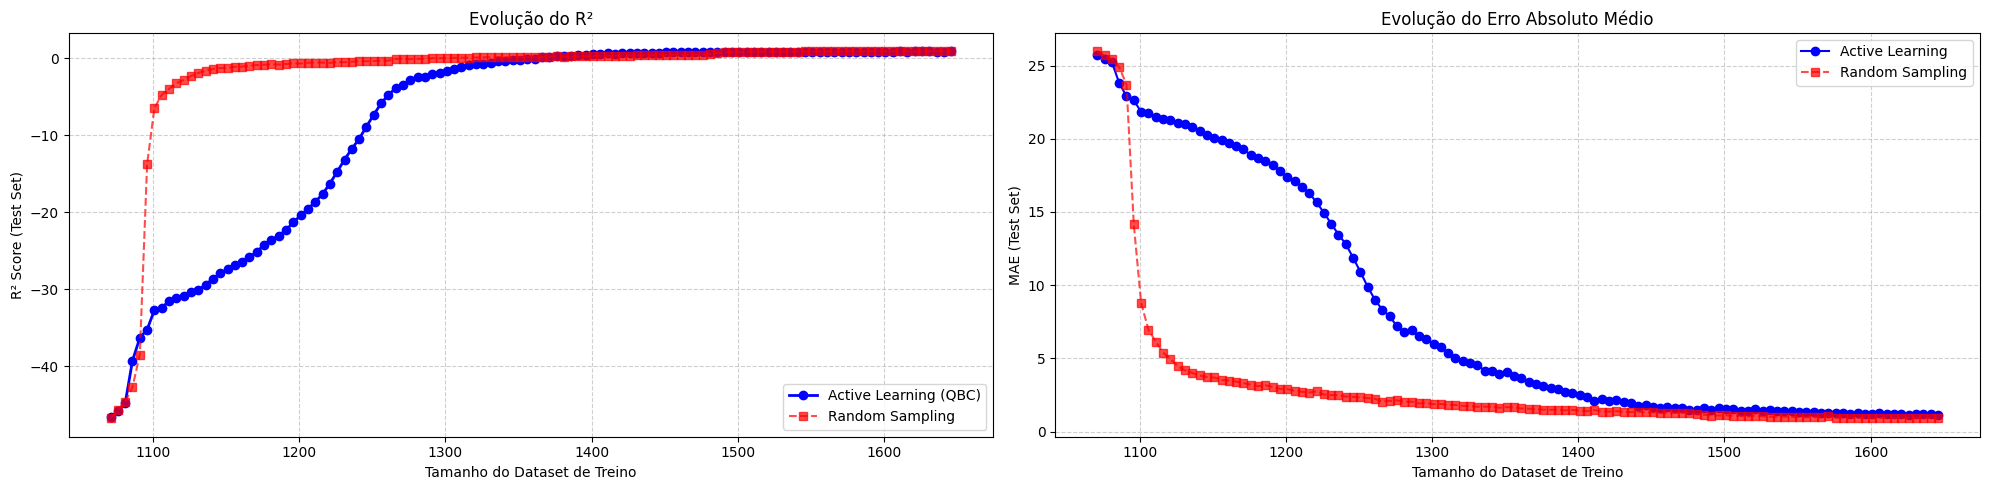

In [44]:
import matplotlib.pyplot as plt

def plot_al_results(r2_act, r2_rnd, mae_act, mae_rnd, initial_size, batch_size):
    """
    Plota comparativo de Active Learning vs Random Sampling.
    
    Args:
        r2_act, r2_rnd: Listas com scores R2
        mae_act, mae_rnd: Listas com scores MAE
        unc_act: Lista com a incerteza média do batch selecionado
        initial_size: Tamanho do treino inicial
        batch_size: Quantas amostras foram adicionadas por passo
    """
    
    # Eixo X: Tamanho do dataset de treino em cada passo
    n_steps = len(r2_act)
    x_axis = [initial_size + (i * batch_size) for i in range(n_steps)]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    # Gráfico 1: R2 Score (Maior é melhor)
    axes[0].plot(x_axis, r2_act, 'b-o', label='Active Learning (QBC)', linewidth=2)
    axes[0].plot(x_axis, r2_rnd, 'r--s', label='Random Sampling', alpha=0.7)
    axes[0].set_xlabel('Tamanho do Dataset de Treino')
    axes[0].set_ylabel('R² Score (Test Set)')
    axes[0].set_title('Evolução do R²')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)
    
    # Gráfico 2: MAE (Menor é melhor)
    axes[1].plot(x_axis, mae_act, 'b-o', label='Active Learning')
    axes[1].plot(x_axis, mae_rnd, 'r--s', label='Random Sampling', alpha=0.7)
    axes[1].set_xlabel('Tamanho do Dataset de Treino')
    axes[1].set_ylabel('MAE (Test Set)')
    axes[1].set_title('Evolução do Erro Absoluto Médio')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# --- Como chamar a função ---
# Certifique-se de ter criado e preenchido a lista acc_unc_active no seu loop
plot_al_results(
    r2_act=acc_r2, 
    r2_rnd=acc_r2_rand, 
    mae_act=acc_mae, 
    mae_rnd=acc_mae_rand, 
    # unc_act=acc_unc_active, # <--- Lista nova que você precisa criar
    initial_size=len(X_train_curr), # ou o valor de n_initial
    batch_size=samples_per_step
)